# Graph Transform Tool

https://petewarden.com/2016/12/30/rewriting-tensorflow-graphs-with-the-gtt/

https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/graph_transforms

# Optimize Trained Models for Inference
## Types of Optimizations
* Remove training-only operations (checkpoint saving, drop out)
* Strip out unused nodes
* Remove debug operations
* Fold batch normalization ops into weights (super cool)
* Round weights
* Quantize weights

# Compare Types of Optimizations

## Original Model (GPU)

### File Size

In [92]:
%%bash

ls -l /root/models/linear/gpu

total 8
drwxr-xr-x 3 root root 4096 May 12 18:42 1494614523
drwxr-xr-x 3 root root 4096 May 12 19:22 1494616922


### Graph

In [93]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/unoptimized_gpu.pb

Found 2 possible inputs: (name=x_observed, type=float(1), shape=[]) (name=y_observed, type=float(1), shape=[]) 
Found 2 variables: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) 
Found 4 possible outputs: (name=gradients/sub_grad/tuple/control_dependency_1, op=Identity) (name=gradients/mul_grad/tuple/control_dependency_1, op=Identity) (name=Merge/MergeSummary, op=MergeSummary) (name=save/Identity, op=Identity) 
Found 25 (25) const parameters, 0 (0) variable parameters, and 25 control_edges
35 nodes assigned to device '/device:CPU:0'63 nodes assigned to device '/device:GPU:0'Op types used: 29 Const, 10 Identity, 9 NoOp, 7 Mul, 7 Reshape, 6 Sum, 6 Shape, 4 Assign, 3 Add, 3 Sub, 3 BroadcastGradientArgs, 2 RestoreV2, 2 VariableV2, 2 RandomUniform, 2 Prod, 2 ApplyGradientDescent, 2 Placeholder, 1 Pack, 1 Neg, 1 MergeV2Checkpoints, 1 RealDiv, 1 MergeSummary, 1 Mean, 1 SaveV2, 1 ScalarSummary, 1 Maximum, 1 ShardedFilename, 1 Square, 1 StringJoin, 1 FloorDiv, 1 Fi

2017-05-12 19:23:26.496378: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights
2017-05-12 19:23:26.496476: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias


### Benchmarks

In [94]:
%%bash

benchmark_model --graph=/root/models/optimize_me/unoptimized_gpu.pb \
    --input_layer=weights,bias,x_observed \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-12 19:23:26.551385: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/unoptimized_gpu.pb]
2017-05-12 19:23:26.551444: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [weights,bias,x_observed]
2017-05-12 19:23:26.551459: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:26.551468: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:26.551476: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:26.551494: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:26.551503: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:26.551524: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:26.551534: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017-05-12 19:23:26

## Strip Unused Nodes

In [95]:
%%bash

transform_graph \
    --in_graph=/root/models/optimize_me/unoptimized_gpu.pb \
    --out_graph=/root/models/optimize_me/strip_unused_optimized_gpu.pb \
    --inputs='x_observed,weights,bias' \
    --outputs='add' \
    --transforms='strip_unused_nodes'

2017-05-12 19:23:27.159252: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes


In [96]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:22 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:22 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:20 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:20 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:22 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [97]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/strip_unused_optimized_gpu.pb

Found 3 possible inputs: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) (name=x_observed, type=float(1), shape=[]) 
No variables spotted.
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
2 nodes assigned to device '/device:CPU:0'3 nodes assigned to device '/device:GPU:0'Op types used: 3 Placeholder, 2 Identity, 1 Add, 1 Mul
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/strip_unused_optimized_gpu.pb --show_flops --logtostderr --input_layer=weights,bias,x_observed --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


In [98]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))
        

In [99]:
input_graph='/root/models/optimize_me/strip_unused_optimized_gpu.pb'
output_dot='/root/notebooks/strip_unused_optimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/strip_unused_optimized_gpu.dot' for graph '/root/models/optimize_me/strip_unused_optimized_gpu.pb'.


In [100]:
%%bash

dot -T png /root/notebooks/strip_unused_optimized_gpu.dot \
    -o /root/notebooks/strip_unused_optimized_gpu.png > /tmp/a.out

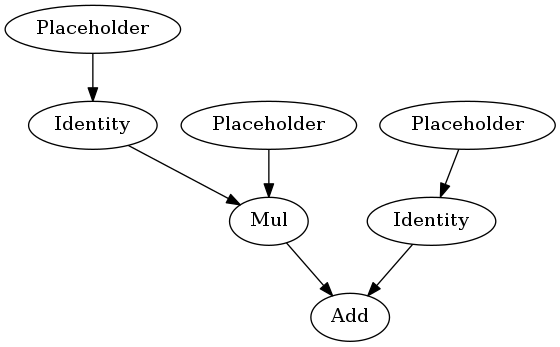

In [101]:
from IPython.display import Image

Image('/root/notebooks/strip_unused_optimized_gpu.png', width=1024, height=768)

### Benchmark

In [102]:
%%bash

benchmark_model --graph=/root/models/optimize_me/strip_unused_optimized_gpu.pb \
    --input_layer=weights,bias,x_observed \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-12 19:23:28.102682: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/strip_unused_optimized_gpu.pb]
2017-05-12 19:23:28.102746: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [weights,bias,x_observed]
2017-05-12 19:23:28.102761: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:28.102769: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:28.102777: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:28.102788: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:28.102797: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:28.102804: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:28.102812: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017-05-

### Fold Constants

In [103]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/unoptimized_gpu.pb \
--out_graph=/root/models/optimize_me/fold_constants_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
fold_constants(ignore_errors=true)'

2017-05-12 19:23:28.707917: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-12 19:23:28.720951: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-05-12 19:23:28.720991: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-05-12 19:23:28.721005: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-05-12 19:23:28.721015: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computation

### File Size

In [104]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:22 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:20 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:20 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:22 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [105]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/fold_constants_optimized_gpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
4 nodes assigned to device '/device:CPU:0'3 nodes assigned to device '/device:GPU:0'Op types used: 2 Identity, 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/fold_constants_optimized_gpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-12 19:23:28.794951: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-12 19:23:28.795059: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [106]:
input_graph='/root/models/optimize_me/fold_constants_optimized_gpu.pb'
output_dot='/root/notebooks/fold_constants_optimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/fold_constants_optimized_gpu.dot' for graph '/root/models/optimize_me/fold_constants_optimized_gpu.pb'.


In [107]:
%%bash

dot -T png /root/notebooks/fold_constants_optimized_gpu.dot \
    -o /root/notebooks/fold_constants_optimized_gpu.png > /tmp/a.out

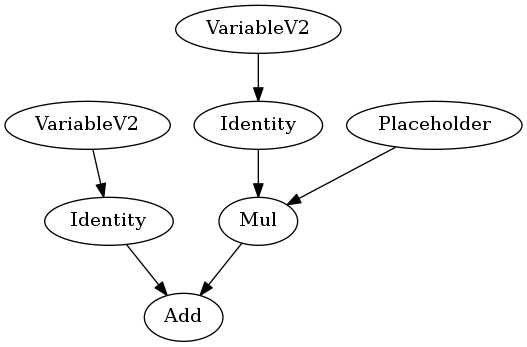

In [108]:
from IPython.display import Image

Image('/root/notebooks/fold_constants_optimized_gpu.png')

### Benchmarks

In [109]:
%%bash

benchmark_model --graph=/root/models/optimize_me/fold_constants_optimized_gpu.pb \
                --input_layer=x_observed,bias,weights \
                --input_layer_type=float,float,float \
                --input_layer_shape=:: \
                --output_layer=add

2017-05-12 19:23:29.463562: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/fold_constants_optimized_gpu.pb]
2017-05-12 19:23:29.463626: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-12 19:23:29.463640: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:29.463649: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:29.463657: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:29.463669: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:29.463678: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:29.463686: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:29.463694: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017-0

## Fold Batch Normalizations
Must run Fold Constants first!

In [110]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/fold_constants_optimized_gpu.pb \
--out_graph=/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
fold_batch_norms
fold_old_batch_norms'

2017-05-12 19:23:30.065769: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_batch_norms
2017-05-12 19:23:30.066054: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_old_batch_norms


### File Size

In [111]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:20 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:20 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:22 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [112]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
4 nodes assigned to device '/device:CPU:0'3 nodes assigned to device '/device:GPU:0'Op types used: 2 Identity, 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-12 19:23:30.761561: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-12 19:23:30.761614: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [113]:
input_graph='/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb'
output_dot='/root/notebooks/fold_batch_norms_optimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/fold_batch_norms_optimized_gpu.dot' for graph '/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb'.


In [114]:
%%bash

dot -T png /root/notebooks/fold_batch_norms_optimized_gpu.dot \
    -o /root/notebooks/fold_batch_norms_optimized_gpu.png > /tmp/a.out

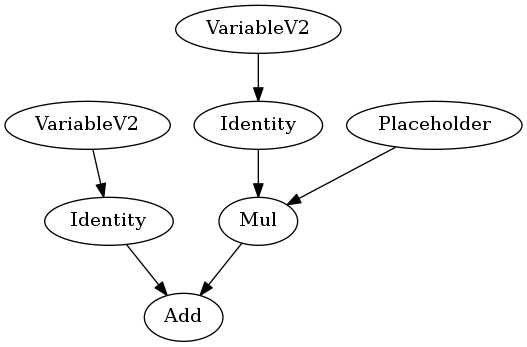

In [115]:
from IPython.display import Image

Image('/root/notebooks/fold_batch_norms_optimized_gpu.png')

### Benchmarks

In [116]:
%%bash

benchmark_model --graph=/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb \
                --input_layer=x_observed,bias,weights \
                --input_layer_type=float,float,float \
                --input_layer_shape=:: \
                --output_layer=add

2017-05-12 19:23:32.308797: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb]
2017-05-12 19:23:32.308870: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-12 19:23:32.308887: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:32.308896: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:32.308905: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:32.308919: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:32.308929: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:32.308939: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:32.308956: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017

## Quantize Weights
Should run Fold Batch Normalization first!

In [117]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb \
--out_graph=/root/models/optimize_me/quantize_weights_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='quantize_weights'

2017-05-12 19:23:32.936912: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_weights


### File Size

In [118]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:20 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:20 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [119]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/quantize_weights_optimized_gpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
4 nodes assigned to device '/device:CPU:0'3 nodes assigned to device '/device:GPU:0'Op types used: 2 Identity, 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/quantize_weights_optimized_gpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-12 19:23:33.403428: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-12 19:23:33.403507: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [120]:
input_graph='/root/models/optimize_me/quantize_weights_optimized_gpu.pb'
output_dot='/root/notebooks/quantize_weights_optimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/quantize_weights_optimized_gpu.dot' for graph '/root/models/optimize_me/quantize_weights_optimized_gpu.pb'.


In [121]:
%%bash

dot -T png /root/notebooks/quantize_weights_optimized_gpu.dot \
    -o /root/notebooks/quantize_weights_optimized_gpu.png > /tmp/a.out

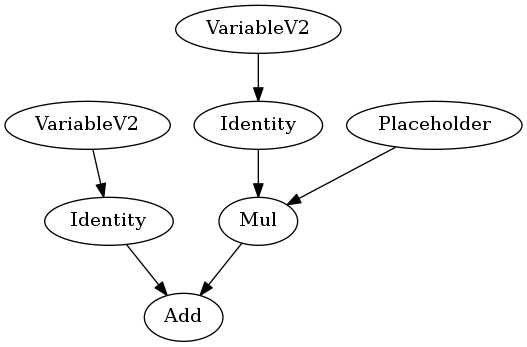

In [122]:
from IPython.display import Image

Image('/root/notebooks/quantize_weights_optimized_gpu.png')

### Benchmarks

In [123]:
%%bash

benchmark_model --graph=/root/models/optimize_me/quantize_weights_optimized_gpu.pb --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add

2017-05-12 19:23:34.960951: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/quantize_weights_optimized_gpu.pb]
2017-05-12 19:23:34.961036: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-12 19:23:34.961057: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:34.961066: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:34.961075: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:34.961089: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:34.961099: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:34.961108: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:34.961116: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017

## Quantize Nodes

In [124]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/fold_batch_norms_optimized_gpu.pb \
--out_graph=/root/models/optimize_me/quantize_nodes_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='quantize_nodes'

2017-05-12 19:23:35.592435: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_nodes


In [125]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:20 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:23 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

In [126]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/quantize_nodes_optimized_gpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 2 (2) const parameters, 0 (0) variable parameters, and 0 control_edges
4 nodes assigned to device '/device:CPU:0'2 nodes assigned to device '/device:GPU:0'Op types used: 2 Const, 2 Identity, 2 Max, 2 Min, 2 QuantizeV2, 2 Reshape, 2 VariableV2, 1 Add, 1 Dequantize, 1 Placeholder, 1 QuantizedMul, 1 RequantizationRange, 1 Requantize
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/quantize_nodes_optimized_gpu.pb --show_flops --logtostderr --input_layer=x_observed,weights,bias --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-12 19:23:36.776398: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights
2017-05-12 19:23:36.776457: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias


In [127]:
input_graph='/root/models/optimize_me/quantize_nodes_optimized_gpu.pb'
output_dot='/root/notebooks/quantize_nodes_optimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/quantize_nodes_optimized_gpu.dot' for graph '/root/models/optimize_me/quantize_nodes_optimized_gpu.pb'.


In [128]:
%%bash

dot -T png /root/notebooks/quantize_nodes_optimized_gpu.dot \
    -o /root/notebooks/quantize_nodes_optimized_gpu.png > /tmp/a.out

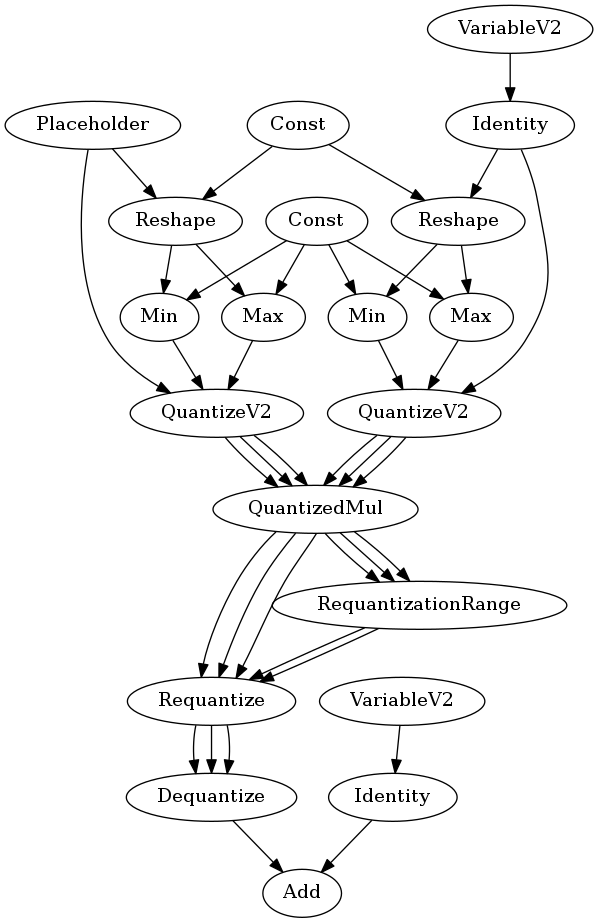

In [129]:
from IPython.display import Image

Image('/root/notebooks/quantize_nodes_optimized_gpu.png')

### Benchmarks

In [130]:
%%bash

benchmark_model --graph=/root/models/optimize_me/quantize_nodes_optimized_gpu.pb \
                --input_layer=x_observed,bias,weights \
                --input_layer_type=float,float,float \
                --input_layer_shape=:: \
                --output_layer=add

2017-05-12 19:23:38.897407: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/quantize_nodes_optimized_gpu.pb]
2017-05-12 19:23:38.897533: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-12 19:23:38.897548: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:38.897572: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:38.897581: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:38.897594: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:38.897604: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:38.897613: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:38.897622: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017-0

## Sort by Execution Order
* aka. Topological Order Sort
* Minimize inference overhead 
* Inputs for a each node are guaranteed to be available on the forward path

In [131]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/unoptimized_gpu.pb \
--out_graph=/root/models/optimize_me/sort_by_execution_order_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
sort_by_execution_order'

2017-05-12 19:23:39.861307: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying sort_by_execution_order


### File Size

In [132]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:20 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:23 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [133]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/sort_by_execution_order_optimized_gpu.pb

Found 2 possible inputs: (name=y_observed, type=float(1), shape=[]) (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 4 possible outputs: (name=save/Identity, op=Identity) (name=gradients/sub_grad/tuple/control_dependency_1, op=Identity) (name=gradients/mul_grad/tuple/control_dependency_1, op=Identity) (name=Merge/MergeSummary, op=MergeSummary) 
Found 25 (25) const parameters, 0 (0) variable parameters, and 25 control_edges
35 nodes assigned to device '/device:CPU:0'63 nodes assigned to device '/device:GPU:0'Op types used: 29 Const, 10 Identity, 9 NoOp, 7 Mul, 7 Reshape, 6 Sum, 6 Shape, 4 Assign, 3 Add, 3 Sub, 3 BroadcastGradientArgs, 2 RestoreV2, 2 VariableV2, 2 RandomUniform, 2 Prod, 2 ApplyGradientDescent, 2 Placeholder, 1 Pack, 1 Neg, 1 MergeV2Checkpoints, 1 RealDiv, 1 MergeSummary, 1 Mean, 1 SaveV2, 1 ScalarSummary, 1 Maximum, 1 ShardedFilename, 1 Square, 1 StringJoin, 1 FloorDiv, 1 Fi

2017-05-12 19:23:41.761649: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-12 19:23:41.761730: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


### Benchmarks

In [134]:
%%bash

benchmark_model --graph=/root/models/optimize_me/sort_by_execution_order_optimized_gpu.pb \
    --input_layer=x_observed,bias,weights \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-12 19:23:42.842731: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/sort_by_execution_order_optimized_gpu.pb]
2017-05-12 19:23:42.842818: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-12 19:23:42.842835: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:42.842861: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:42.842871: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:42.842886: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:42.842897: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:42.842907: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:42.842930: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: 

## Combine All Optimizations

In [135]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/unoptimized_gpu.pb \
--out_graph=/root/models/optimize_me/fully_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
add_default_attributes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms
quantize_weights
quantize_nodes
strip_unused_nodes
sort_by_execution_order'

2017-05-12 19:23:43.632980: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying add_default_attributes
2017-05-12 19:23:43.645954: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-12 19:23:43.653809: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-12 19:23:43.654766: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-05-12 19:23:43.654796: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-05-12 19:23:43.654809: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU com

### File Size

In [136]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:23 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:20 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:23 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [137]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/fully_optimized_gpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 2 (2) const parameters, 0 (0) variable parameters, and 0 control_edges
2 nodes assigned to device '/device:CPU:0'2 nodes assigned to device '/device:GPU:0'Op types used: 2 Const, 2 Max, 2 Min, 2 QuantizeV2, 2 Reshape, 2 VariableV2, 1 Add, 1 Dequantize, 1 Placeholder, 1 QuantizedMul, 1 RequantizationRange, 1 Requantize
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/fully_optimized_gpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-12 19:23:46.380594: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-12 19:23:46.380663: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [138]:
input_graph='/root/models/optimize_me/fully_optimized_gpu.pb'
output_dot='/root/notebooks/fully_optimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/fully_optimized_gpu.dot' for graph '/root/models/optimize_me/fully_optimized_gpu.pb'.


In [139]:
%%bash

dot -T png /root/notebooks/fully_optimized_gpu.dot \
    -o /root/notebooks/fully_optimized_gpu.png > /tmp/a.out

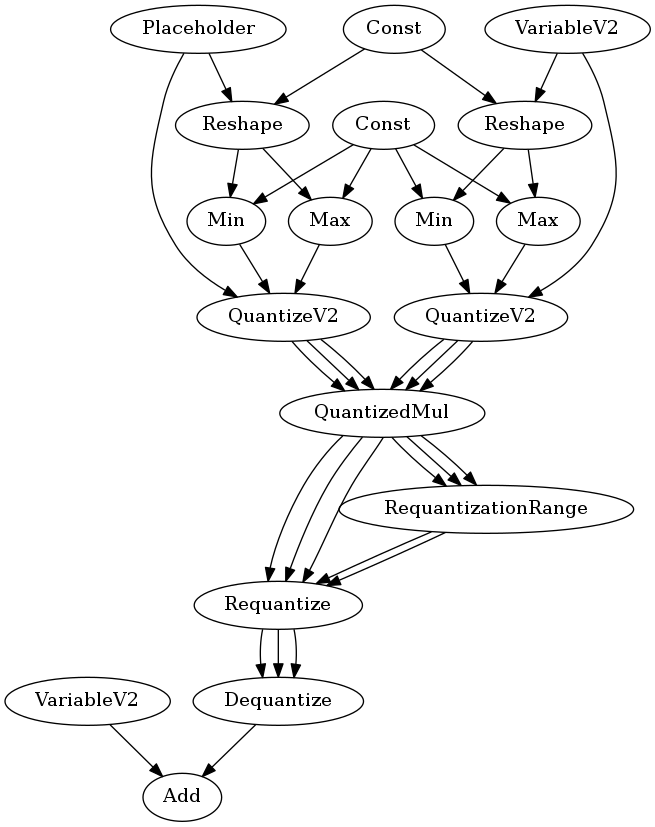

In [140]:
from IPython.display import Image

Image('/root/notebooks/fully_optimized_gpu.png')

### Benchmarks

In [141]:
%%bash

benchmark_model --graph=/root/models/optimize_me/fully_optimized_gpu.pb \
    --input_layer=weights,x_observed,bias \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-12 19:23:47.732921: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/fully_optimized_gpu.pb]
2017-05-12 19:23:47.733019: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [weights,x_observed,bias]
2017-05-12 19:23:47.733035: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-12 19:23:47.733045: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-12 19:23:47.733093: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-12 19:23:47.733107: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-12 19:23:47.733116: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-12 19:23:47.733125: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-12 19:23:47.733133: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
2017-05-12 19:2

## Obfuscate Names
* Shorten and mangle internal graph node names

In [142]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/fully_optimized_gpu.pb \
--out_graph=/root/models/optimize_me/obfuscate_names_optimized_gpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
obfuscate_names'

2017-05-12 19:23:48.405777: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying obfuscate_names


### File Size

In [143]:
%%bash

ls -l /root/models/optimize_me/

total 120
-rw-r--r-- 1 root root   599 May 12 19:14 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_batch_norms_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 fold_constants_optimized_gpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:16 fully_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 12 19:23 fully_optimized_gpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:16 obfuscate_names_optimized_cpu.pb
-rw-r--r-- 1 root root  1086 May 12 19:23 obfuscate_names_optimized_gpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:14 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2507 May 12 19:23 quantize_nodes_optimized_gpu.pb
-rw-r--r-- 1 root root   599 May 12 19:14 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 12 19:23 quantize_weights_optimized_gpu.pb
-rw-r--r-- 1 root root 13428 May 12 19:15 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root 1351

### Graph

In [144]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/obfuscate_names_optimized_gpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=6, type=float(1), shape=[]) (name=7, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 2 (2) const parameters, 0 (0) variable parameters, and 0 control_edges
2 nodes assigned to device '/device:CPU:0'2 nodes assigned to device '/device:GPU:0'Op types used: 2 Const, 2 Max, 2 Min, 2 QuantizeV2, 2 Reshape, 2 VariableV2, 1 Add, 1 Dequantize, 1 Placeholder, 1 QuantizedMul, 1 RequantizationRange, 1 Requantize
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/obfuscate_names_optimized_gpu.pb --show_flops --logtostderr --input_layer=x_observed,6,7 --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-12 19:23:49.928540: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for node6
2017-05-12 19:23:49.928611: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for node7
